In [ ]:
%reset -f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


99


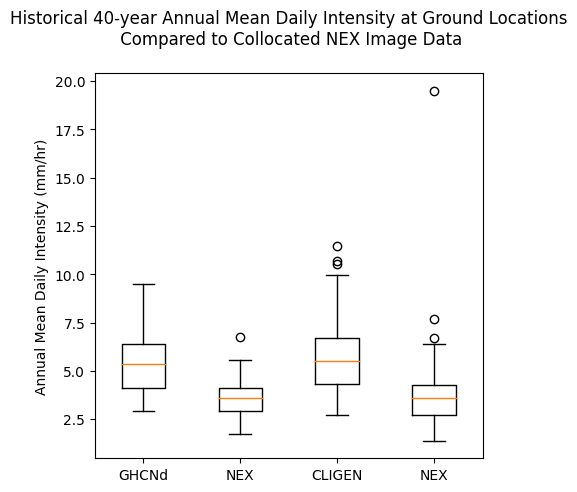

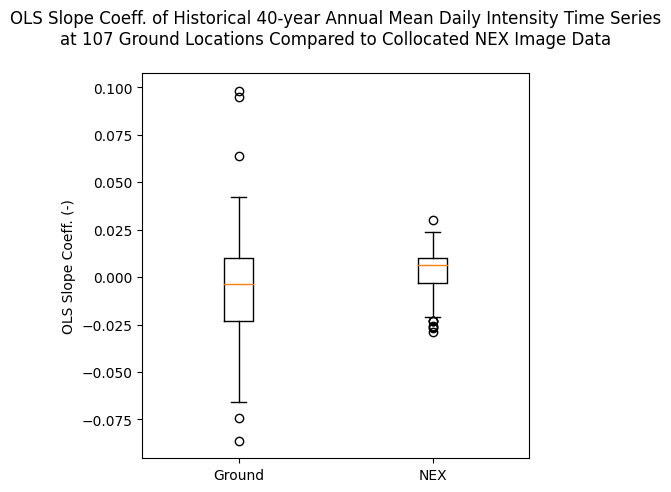

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scipy
import numpy as np
import os

ghcnresFILE = '/content/drive/My Drive/Colab Notebooks/GHCN_Historical_Annual_Mean_MEANP_Trends_Results.csv'
nexresFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Historical_Annual_Mean_MEANP_Trends_Results.csv'
ghcndatFILE = '/content/drive/My Drive/Colab Notebooks/GHCN_Historical_Annual_Mean_MEANP_Trends_Data.csv'
nexdatFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Historical_Annual_Mean_MEANP_Trends_Data.csv'
parFOLDER = '/content/drive/My Drive/Colab Notebooks/CLIGEN/2015parfiles/2015parfiles/2015parfiles'
parresFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Historical_Annual_Mean_MEANP_Trends_Results_CLINET.csv'
pardatFILE = '/content/drive/My Drive/Colab Notebooks/NEX_Historical_Annual_Mean_MEANP_Trends_Data_CLINET.csv'


ndays_months = [31., 28.25, 31., 30., 31., 30., 31., 31., 30., 31., 30., 31.]

cli = []
par_files = os.listdir(parFOLDER)
for parf in par_files:

  if parf[:2] in ['az', 'nv', 'nm', 'ut', 'US']:
    stationID = parf.strip('.par')
    with open(os.path.join(parFOLDER, parf)) as f:
      lines = f.readlines()

    for line in lines:
      label = line[:8]
      label = label.rstrip().lstrip()
      dataline = line[8:]

      if label == 'LATT=':
        y = line.split('=')[1].strip('LONG').strip()
        x = line.split('=')[2].strip('YEARS').strip()
      elif label == 'MEAN P':
        meanp_row = [float(dataline[k*6:k*6+6]) for k in range(0,12)]
      elif label == 'P(W/W)':
        pww_row = [float(dataline[k*6:k*6+6]) for k in range(0,12)]
      elif label == 'P(W/D)':
        pwd_row = [float(dataline[k*6:k*6+6]) for k in range(0,12)]
      else:
        pass

    wet_days_list = []
    for i, meanp in enumerate(meanp_row):
      wet_days_mo = ndays_months[i]*(pwd_row[i]/(1-pww_row[i]+pwd_row[i]))
      wet_days_list.append(wet_days_mo)

    wet_days = sum(wet_days_list)
    weighted_avgs = []
    for i, meanp in enumerate(meanp_row):
      wet_days_mo = wet_days_list[i]
      weighted = (wet_days_mo/wet_days)*meanp
      weighted_avgs.append(weighted)

    ann_meanp = sum(weighted_avgs)*25.4

    cli.append(ann_meanp)

nex_cli_df = pd.read_csv(pardatFILE)
nex_cli = []
for col in nex_cli_df.columns:
  nex_cli.append(nex_cli_df[col].mean())

with open(ghcnresFILE) as f:
  lines = f.readlines()

ghcn_xyz = []
for line in lines[1:]:
  row = line.strip('\n').split(',')
  stationID = row[0]
  x = float(row[1])
  y = float(row[2])
  slope = float(row[3])
  ghcn_xyz.append([stationID, x, y, slope])

ghcn_xyz = sorted(ghcn_xyz, key=lambda element:(element[0], element[1]), reverse=True)

with open(nexresFILE) as f:
  lines = f.readlines()

nex_xyz = []
for line in lines[1:]:
  row = line.strip('\n').split(',')
  stationID = row[0]
  x = float(row[1])
  y = float(row[2])
  slope = float(row[3])
  nex_xyz.append([stationID, x, y, slope])

ghcn_ids = [elem[0] for elem in ghcn_xyz]
nex_ids = [elem[0] for elem in nex_xyz]
stationID_dict = {id:nex_ids[i] for i, id in enumerate(ghcn_ids)}

ghcn_df = pd.read_csv(ghcndatFILE)
nex_df = pd.read_csv(nexdatFILE)

ghcn = []
nex = []
for key in stationID_dict:
  ghcn.append(ghcn_df[key].mean())
  nex.append(nex_df[stationID_dict[key]].mean())

#outlier filter below
for i, val in enumerate(ghcn):
  if val > 30.:
    j = i
    print(j)
ghcn = [val for i, val in enumerate(ghcn) if i != j]
nex = [val for i, val in enumerate(nex) if i != j]
#outlier filter above



fig, ax = plt.subplots(figsize=(5, 5))

ax.boxplot([ghcn, nex, cli, nex_cli])
ax.set_title('Historical 40-year Annual Mean Daily Intensity at Ground Locations\n Compared to Collocated NEX Image Data\n')
ax.set_ylabel('Annual Mean Daily Intensity (mm/hr)')
ax.set_xticks([1, 2, 3, 4], ['GHCNd', 'NEX', 'CLIGEN', 'NEX'])
plt.show()



ghcn = [row[3] for row in ghcn_xyz]
nex = [row[3] for row in nex_xyz]

#outlier filter below
for i, val in enumerate(ghcn):
  if val < -1.:
    j = i
ghcn = [val for i, val in enumerate(ghcn) if i != j]
nex = [val for i, val in enumerate(nex) if i != j]
#outlier filter above

fig, ax = plt.subplots(figsize=(5, 5))

ax.boxplot([ghcn, nex])
ax.set_title('OLS Slope Coeff. of Historical 40-year Annual Mean Daily Intensity Time Series\nat {} Ground Locations Compared to Collocated NEX Image Data\n'.format(len(ghcn)))
ax.set_ylabel('OLS Slope Coeff. (-)')
ax.set_xticks([1, 2], ['Ground', 'NEX'])

plt.show()

